# Project 3: 

## Table of contents

- [Background](#Background)<br>
- [Importing packages](#Importing-packages)<br>
- [Getting the Data](#Getting-the-Data)<br>
- [Data Cleaning](#Data-Cleaning)<br>
- [Exploratory Data Analysis & Visualizations](#Exploratory-Data-Analysis-&-Visualizations)<br>
- [Text Classification](#Text-Classification)<br>
- [Conclusions & Findings](#Conclusions-&-Findings)<br>




<font color = 'red'> Points to improve on:
1. Can use f1 score for model assessment
2. Seasonality analysis on datasaet
3. Post length as added dimension

## Background

Machine learning and statistics are 2 closely related and intertwined fields, with many machine learning models being heavily based on statistical theories. 

Statistics contributes key concepts such as probability theory, sampling distributions, statistical inference, and experimental design, which are essential for understanding the theoretical underpinnings and evaluating the efficacy of machine learning models. In turn, machine learning complements statistics by offering computational approaches that can handle large-scale, high-dimensional datasets and complex models. Machine learning algorithms provide powerful tools for automated feature extraction, pattern recognition, and predictive modeling. They excel at discovering intricate relationships, non-linear dependencies, and intricate structures within data that may be challenging to capture using traditional statistical methods alone.

The goal of this project will be to use Natural Language Processing (NLP) on the corpus of data scraped from <b>r/statistics</b> and <b>r/machinelearning</b> to 
explore the intersection of statistics and machine learning and gain a deeper understanding of how these two fields intertwine. After which, we will be building a text classifier to classify whether the post belongs to r/machinelearning or r/statistics. <br><br>


This project will be employing the following 3 techniques to achieve the above-mentioned outcome:

>Topic Modeling: Apply topic modeling techniques, to uncover latent topics within the subreddit threads. This can help identify the dominant themes discussed in the communities, understand the distribution of topics over time, and discover any emerging trends.

>Community Detection: Apply community detection algorithms to identify clusters or groups of users with similar interests or interactions. This can help uncover different subgroups within the communities and understand the dynamics of user interactions and collaborations.

>Text Classification: Build a text classifier to automatically categorize posts or comments into relevant categories based on their content. For example, I can classify posts into topics like "data analysis," "machine learning algorithms," or "experimental design." This can assist in organizing and retrieving information from the subreddits more effectively.



Success of this project will be evaluated via whether we can identify any distinct topics/communities from the posts scrapped, as well as whether we can build a classifier that can accurately (above 90% accuracy) classify a post into r/statistics or r/machinelearning.

## Importing packages

In [1]:
#Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings


#Loading models
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay

import re

from helper import *

sns.set_style("whitegrid")
sns.set_palette("RdBu")
%matplotlib inline

In [2]:
#Setting options

pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)

## Getting the Data

In [3]:
# # Scraping machinelearning and statistics subreddits using custom function get_subreddit_posts

# ml_data = get_subreddit_posts(subreddit_name='machinelearning',post_limit=1050)
# stats_data = get_subreddit_posts(subreddit_name='statistics',post_limit=1050)

# # Saving to dataframe

# ml = pd.DataFrame(ml_data)
# stats = pd.DataFrame(stats_data)
# print(f"Shape of ML: {ml.shape}")
# print(f"Shape of stats: {stats.shape}")

# ml.to_csv("../data/machinelearning_subreddit_praw.csv")
# stats.to_csv("../data/statistics_subreddit_praw.csv")



In [4]:
#Loading the data

ml = pd.read_csv('../data/machinelearning_subreddit_praw.csv').drop("Unnamed: 0",axis=1)
stats = pd.read_csv('../data/statistics_subreddit_praw.csv').drop("Unnamed: 0",axis=1)

ml.set_index('time',inplace=True)
stats.set_index('time',inplace=True)



In [5]:
print(f"Date range of posts scrapped from r/machinelearning is from {min(ml.index)} to {max(ml.index)}")
print(f"Date range of posts scrapped from r/statistics is from {min(stats.index)} to {max(stats.index)}")

Date range of posts scrapped from r/machinelearning is from 2023-04-03 07:00:17 to 2023-05-27 15:46:09
Date range of posts scrapped from r/statistics is from 2023-02-19 06:53:51 to 2023-05-27 14:10:07


In [6]:
print(f"Number of unique posts scraped from r/machinelearning: {ml['title'].nunique()}")
print(f"Number of unique posts scraped from r/statistics: {stats['title'].nunique()}")

Number of unique posts scraped from r/machinelearning: 975
Number of unique posts scraped from r/statistics: 999


## Data Cleaning

In [7]:
ml.head()

,title,content,top_10_comments,upvotes,no_of_comments,url
time,,,,,,
2023-05-27 15:46:09,[P] Training and serving GPT-2 using Keras-CV ...,"Hi, just want to share my latest project in wh...",[],1,0,https://www.reddit.com/r/MachineLearning/comme...
2023-05-27 13:09:54,Prediction of range [D],I’m using neural networks and tensor flow on p...,[],0,0,https://www.reddit.com/r/MachineLearning/comme...
2023-05-27 08:44:16,[D] Learning Theory,I remember taking a class in college about sta...,['The Performer paper has some learning theory...,5,1,https://www.reddit.com/r/MachineLearning/comme...
2023-05-27 07:49:25,[R] Sophia: A Scalable Stochastic Second-order...,NaN,"['Wrong repo link, this one is official: https...",24,4,https://arxiv.org/abs/2305.14342
2023-05-27 07:12:33,[P] Instruction following codegen model you ca...,Releasing https://huggingface.co/sahil2801/ins...,['What dataset does it use?'],2,1,https://www.reddit.com/r/MachineLearning/comme...


In [8]:
stats.head()

,title,content,top_10_comments,upvotes,no_of_comments,url
time,,,,,,
2023-05-27 14:10:07,[R]I'm looking for statistics about how many p...,It would be great if the numbers are from 2022...,['This is a sub where people can seek advice o...,0,2,https://www.reddit.com/r/statistics/comments/1...
2023-05-27 13:38:35,[D] Short Time Series Forecasting,"Hi, I would like to know what sort of approach...","[""How short is short?\n\nExponential smoothing...",1,1,https://www.reddit.com/r/statistics/comments/1...
2023-05-27 08:01:27,[Q] is it a good idea to start a job that is n...,I recently got a job offer for a chemistry ass...,['Sounds like the data analysis connection is ...,2,5,https://www.reddit.com/r/statistics/comments/1...
2023-05-27 07:49:20,[Q] Are entry-level data scientist positions t...,I am a foreign student in the United States of...,"[""You're going to do fine in 2025. Nobody can ...",6,5,https://www.reddit.com/r/statistics/comments/1...
2023-05-27 05:52:03,[Q] What kind of jobs should I be looking for ...,I haven’t gotten a job yet and I’ve applied fo...,['Data Analyst positions would be great. If yo...,18,9,https://www.reddit.com/r/statistics/comments/1...


In [9]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 980 entries, 2023-05-27 15:46:09 to 2023-04-03 07:00:17
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            980 non-null    object
 1   content          862 non-null    object
 2   top_10_comments  980 non-null    object
 3   upvotes          980 non-null    int64 
 4   no_of_comments   980 non-null    int64 
 5   url              980 non-null    object
dtypes: int64(2), object(4)
memory usage: 53.6+ KB


In [10]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 2023-05-27 14:10:07 to 2023-02-19 06:53:51
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            999 non-null    object
 1   content          970 non-null    object
 2   top_10_comments  999 non-null    object
 3   upvotes          999 non-null    int64 
 4   no_of_comments   999 non-null    int64 
 5   url              999 non-null    object
dtypes: int64(2), object(4)
memory usage: 54.6+ KB


---

We notice that most posts have a bracket with a tag in front of them, eg [R]. The following table shows the corresponding tags and their abbreviations:

| **Tag**      | **Abbreviation (r/statistics)** | **Abbreviation (r/machinelearning)** |
|--------------|---------------------------------|--------------------------------------|
| [Research]   | [R]                             | [R]                                  |
| [Software]   | [S]                             |                                      |
| [Question]   | [Q]                             |                                      |
| [Discussion] | [D]                             | [D]                                  |
| [Education]  | [E]                             |                                      |
| [Career]     | [C]                             |                                      |
| [Meta]       | [M]                             |                                      |
| [News]       |                                 | [N]                                  |
| [Project]    |                                 | [P]                                  |

Lets create a new column with the post's corresponding tags

In [11]:
ml['tags'] = ml['title'].apply(extract_tags)
stats['tags'] = stats['title'].apply(extract_tags)


In [12]:
ml['tags'].value_counts()

[D]             476
[P]             195
[R]             162
[N]              51
[Discussion]     33
[Project]        22
                 18
[Research]       12
[News]            7
[research]        1
[2103.10050]      1
[PROJECT]         1
[d]               1
Name: tags, dtype: int64

In [13]:
stats['tags'].value_counts()

[Q]             717
[Question]       77
[E]              63
[D]              36
[R]              29
[S]              17
[Research]       12
[C]              12
[Education]       7
[question]        6
[q]               5
[Software]        4
[Career]          3
[Discussion]      3
[research]        2
[M]               1
[career]          1
[Meta]            1
[meta]            1
[[Q]              1
[QUESTION]        1
Name: tags, dtype: int64

In [14]:
#Cleaning the rows of the tags

ml['tags'] = ml['tags'].replace({"[Discussion]":"[D]",\
                                 "[Project]":"[P]","[Research]":"[R]","[News]":"[N]",\
                                "[research]":"[R]","[PROJECT]":"[P]","[d]":"[D]"})

stats['tags'] = stats['tags'].replace({"[Question]":"[Q]","[Research]":"[R]","[Education]":"[E]",\
                                      "[question]":"[Q]","[Software]":"[S]","[Career]":"[C]",\
                                      "[Discussion]":"[D]","[research]":"[R]","[career]":"[C]",\
                                      "[Meta]":"[M]","[meta]":"[M]","[[Q]":"[Q]","[QUESTION]":"[Q]","[q]":"[Q]"})


In [15]:
#Exploring the missing tags from ml

missing_tags_ml = ml[ml['tags']==""]
for title in missing_tags_ml['title'].values[:5]:
    print(title)

print("="*80)

for content in missing_tags_ml['content'].values[:10]:
    print(content)

Landmark Attention: Random-Access Infinite Context Length for Transformers
Voyager: An LLM-powered learning agent in Minecraft
DeepMind: Model evaluation for extreme risks
Gorilla: Large Language Model Connected with Massive APIs
QLoRA: Efficient Finetuning of Quantized LLMs
nan
nan
nan
nan
nan
*Schmidhuber interview expressing his views on the future of AI and AGI.*

*Original [source](https://www.forbes.com/sites/hessiejones/2023/05/23/juergen-schmidhuber-renowned-father-of-modern-ai-says-his-lifes-work-wont-lead-to-dystopia/). I think the interview is of interest to r/MachineLearning, and presents an alternate view, compared to other influential leaders in AI.*

**Juergen Schmidhuber, Renowned 'Father Of Modern AI,' Says His Life’s Work Won't Lead To Dystopia**

*May 23, 2023. Contributed by [Hessie Jones](https://twitter.com/hessiejones).*

Amid the growing concern about the impact of more advanced artificial intelligence (AI) technologies on society, there are many in the technolo

Most of the untagged posts in ml look like discussion topics, hence we shall impute these missing values with "[D]".

In [16]:
ml['tags'] = ml['tags'].replace({"":"[D]"})

In [17]:
#Exploring the tag "2103.10050"

ml[ml['tags']=="[2103.10050]"][['title','content']].values[:3]


array([['[2103.10050] Spatio-temporal Crop Classification On Volumetric Data',
        'Large-area crop classification using multi-spectral imagery is a widely studied problem for several decades and is generally addressed using classical Random Forest classifier. Recently, deep convolutional neural networks (DCNN) have been proposed. However, these methods only achieved results comparable with Random Forest. In this work, we present a novel CNN based architecture for large-area crop classification. Our methodology combines both spatio-temporal analysis via 3D CNN as well as temporal analysis via 1D CNN. We evaluated the efficacy of our approach on Yolo and Imperial county benchmark datasets. Our combined strategy outperforms both classical as well as recent DCNN based methods in terms of classification accuracy by 2% while maintaining a minimum number of parameters and the lowest inference time.']],
      dtype=object)

Looks like a discussion topic too - lets impute this with "[D]"

In [18]:
ml['tags'] = ml['tags'].replace({"[2103.10050]":"[D]"})

In [19]:
ml['tags'].value_counts()

[D]    529
[P]    218
[R]    175
[N]     58
Name: tags, dtype: int64

---

A topic can be deemed as popular if it has a significant number of comments and upvotes. Lets create a column "popularity_score" that measures the degree of popularity of a post, by multiplying upvotes with the no_of_comments, then taking the log of the product

In [20]:
ml["popularity_score"] = np.log(ml['upvotes']*ml['no_of_comments']).replace(-np.inf, 0)
stats["popularity_score"] = np.log(stats['upvotes']*stats['no_of_comments']).replace(-np.inf, 0)

C:\Users\tanya\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tanya\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<br>

---

Exploring the nil contents in ml and stats, under the content column

In [21]:
ml[ml['content'].isnull()]['url'][:5]

time
2023-05-27 07:49:25          https://arxiv.org/abs/2305.14342
2023-05-27 07:05:57          https://arxiv.org/abs/2305.16300
2023-05-27 00:28:34    https://www.reddit.com/gallery/13shsz4
2023-05-26 20:34:50          https://arxiv.org/abs/2305.16291
2023-05-26 18:08:23          https://arxiv.org/abs/2305.15324
Name: url, dtype: object

In [22]:
stats[stats['content'].isnull()]['url'][:5]

time
2023-05-23 09:40:50    /r/AskStatistics/comments/13p4abr/recommendati...
2023-05-20 05:46:18     /r/econometrics/comments/13lc63c/itt_estimation/
2023-05-15 17:35:19    https://www.reddit.com/r/statistics/comments/1...
2023-05-12 23:36:25    /r/AskStatistics/comments/13dwplr/can_someone_...
2023-05-12 01:04:37    /r/rstats/comments/13et720/mixed_models_parame...
Name: url, dtype: object

There are some missing values for content field, however that isnt really an issue because the gist of the post for those posts are in the title itself. These posts are also usually linked to external sites or videos. We will impute these cells with the string 'nil content' after concatenating the  2 dataframes. <br>

<br><br>Next, we create the target labels for the 2 dataframes before concatenating the 2 dataframes into one.

In [23]:
ml['is_ml'] = 1
stats['is_ml']=0

df = pd.concat([ml,stats],axis='rows')


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 2023-05-27 15:46:09 to 2023-02-19 06:53:51
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             1979 non-null   object 
 1   content           1832 non-null   object 
 2   top_10_comments   1979 non-null   object 
 3   upvotes           1979 non-null   int64  
 4   no_of_comments    1979 non-null   int64  
 5   url               1979 non-null   object 
 6   tags              1979 non-null   object 
 7   popularity_score  1979 non-null   float64
 8   is_ml             1979 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 154.6+ KB


---

<br>Imputing nil contents with 'No content'<br>

In [25]:
df['content'] = df['content'].fillna('nil content')

---

<br>Splitting the multiple comments and then rejoining them into one string

In [26]:
df['top_10_comments'] = df['top_10_comments'].str.split("\',")
df['top_10_comments'] = df['top_10_comments'].apply(lambda x: '\t'.join(x))

In [27]:
df['top_10_comments'][3]

'[\'Wrong repo link, this one is official: https://github.com/Liuhong99/Sophia\t "Abstract:\\n\\n>Given the massive cost of language model pre-training, a non-trivial improvement of the optimization algorithm would lead to a material reduction on the time and cost of training. Adam and its variants have been state-of-the-art for years, and more sophisticated second-order (Hessian-based) optimizers often incur too much per-step overhead. In this paper, we propose Sophia, Second-order Clipped Stochastic Optimization, a simple scalable second-order optimizer that uses a light-weight estimate of the diagonal Hessian as the pre-conditioner. The update is the moving average of the gradients divided by the moving average of the estimated Hessian, followed by element-wise clipping. The clipping controls the worst-case update size and tames the negative impact of non-convexity and rapid change of Hessian along the trajectory. Sophia only estimates the diagonal Hessian every handful of iteration

---

Removing the tags from the title columns (eg [D], [R] etc)

In [28]:
df['title'] = df['title'].str.replace(r'\[.*?\]', '', regex=True)
df['title'].head()

time
2023-05-27 15:46:09     Training and serving GPT-2 using Keras-CV and...
2023-05-27 13:09:54                                 Prediction of range 
2023-05-27 08:44:16                                      Learning Theory
2023-05-27 07:49:25     Sophia: A Scalable Stochastic Second-order Op...
2023-05-27 07:12:33     Instruction following codegen model you can u...
Name: title, dtype: object

<br><br> We next tokenize the data

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 2023-05-27 15:46:09 to 2023-02-19 06:53:51
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             1979 non-null   object 
 1   content           1979 non-null   object 
 2   top_10_comments   1979 non-null   object 
 3   upvotes           1979 non-null   int64  
 4   no_of_comments    1979 non-null   int64  
 5   url               1979 non-null   object 
 6   tags              1979 non-null   object 
 7   popularity_score  1979 non-null   float64
 8   is_ml             1979 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 154.6+ KB


In [30]:
# #Tokenizing columns using custom tokenizer function
# df['tokenized_title'] = df['title'].apply(tokenize_text).apply(' '.join)
# df['tokenized_content'] = df['content'].apply(tokenize_text).apply(' '.join)
# df['tokenized_topcomments'] = df['top_10_comments'].apply(tokenize_text).apply(' '.join)

For ease of loading and rerunning the script, we will save df as a csv file and then reload it for EDA. The above code to tokenize the 3 columns
will be commented out

In [31]:
# df.to_csv('../data/df_tokenized.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 2023-05-27 15:46:09 to 2023-02-19 06:53:51
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             1979 non-null   object 
 1   content           1979 non-null   object 
 2   top_10_comments   1979 non-null   object 
 3   upvotes           1979 non-null   int64  
 4   no_of_comments    1979 non-null   int64  
 5   url               1979 non-null   object 
 6   tags              1979 non-null   object 
 7   popularity_score  1979 non-null   float64
 8   is_ml             1979 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 154.6+ KB


In [33]:
df = pd.read_csv('../data/df_tokenized.csv',parse_dates = ['time'], index_col='time')

df[['title','content','top_10_comments','tokenized_title','tokenized_content','tokenized_topcomments']] =\
df[['title','content','top_10_comments','tokenized_title','tokenized_content','tokenized_topcomments']].astype('string')

df['tokenized_topcomments'] = df['tokenized_topcomments'].fillna("nil")

df['tags'] = df['tags'].astype('category')


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1979 entries, 2023-05-27 15:46:09 to 2023-02-19 06:53:51
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  1979 non-null   string  
 1   content                1979 non-null   string  
 2   top_10_comments        1979 non-null   string  
 3   upvotes                1979 non-null   int64   
 4   no_of_comments         1979 non-null   int64   
 5   url                    1979 non-null   object  
 6   tags                   1979 non-null   category
 7   popularity_score       1979 non-null   float64 
 8   is_ml                  1979 non-null   int64   
 9   tokenized_title        1979 non-null   string  
 10  tokenized_content      1979 non-null   string  
 11  tokenized_topcomments  1979 non-null   string  
dtypes: category(1), float64(1), int64(3), object(1), string(6)
memory usage: 187.8+ KB


---

# Exploratory Data Analysis & Visualizations

### Distributions in each subreddit

In [35]:
df['is_ml'].value_counts()

0    999
1    980
Name: is_ml, dtype: int64

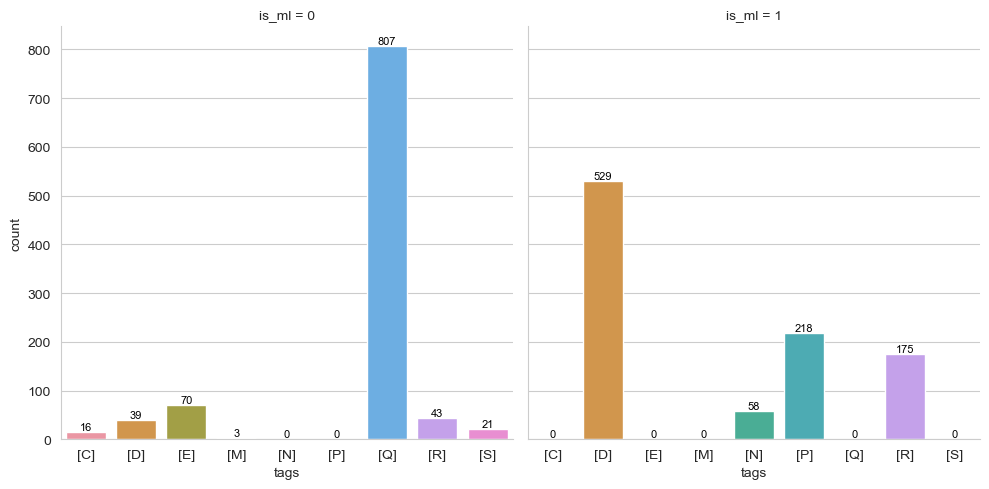

In [36]:
#Plotting distribution of post types (ie tags) in each subreddit thread
catplot = sns.catplot(data=df, x='tags', col='is_ml', kind='count')

for ax in catplot.fig.axes:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{p.get_height():.0f}', 
                fontsize=8, color='black', ha='center', va='bottom')

plt.show()

Posts in r/statistics are predominantly queries, whereas most posts in r/machinelearning are discussions, projects and research. 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1979 entries, 2023-05-27 15:46:09 to 2023-02-19 06:53:51
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  1979 non-null   string  
 1   content                1979 non-null   string  
 2   top_10_comments        1979 non-null   string  
 3   upvotes                1979 non-null   int64   
 4   no_of_comments         1979 non-null   int64   
 5   url                    1979 non-null   object  
 6   tags                   1979 non-null   category
 7   popularity_score       1979 non-null   float64 
 8   is_ml                  1979 non-null   int64   
 9   tokenized_title        1979 non-null   string  
 10  tokenized_content      1979 non-null   string  
 11  tokenized_topcomments  1979 non-null   string  
dtypes: category(1), float64(1), int64(3), object(1), string(6)
memory usage: 187.8+ KB


---

### Popularity patterns
We will be looking at which types of posts are popular amongst each subreddit thread.

<br><br> Lets look at the popularity scores for the tags [D], [Q], [P] and [R]

In [38]:
tags_of_interest = ['[D]','[Q]','[P]','[R]']

df_tags = df[df['tags'].isin(tags_of_interest)]
df_tags['tags'].unique()

['[P]', '[D]', '[R]', '[Q]']
Categories (9, object): ['[C]', '[D]', '[E]', '[M]', ..., '[P]', '[Q]', '[R]', '[S]']

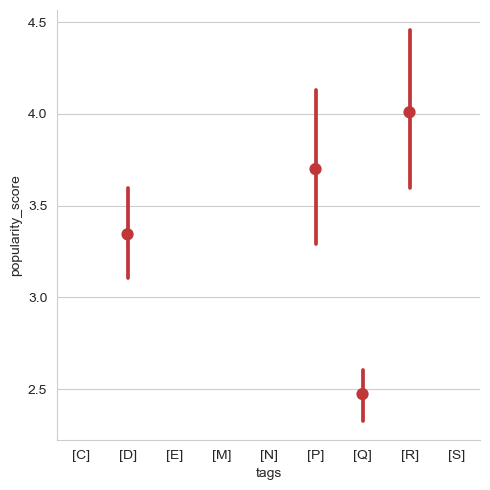

In [39]:
#Plotting overall popularity score distribution
sns.catplot(data=df_tags, x='tags', y='popularity_score',kind='point', join=False)

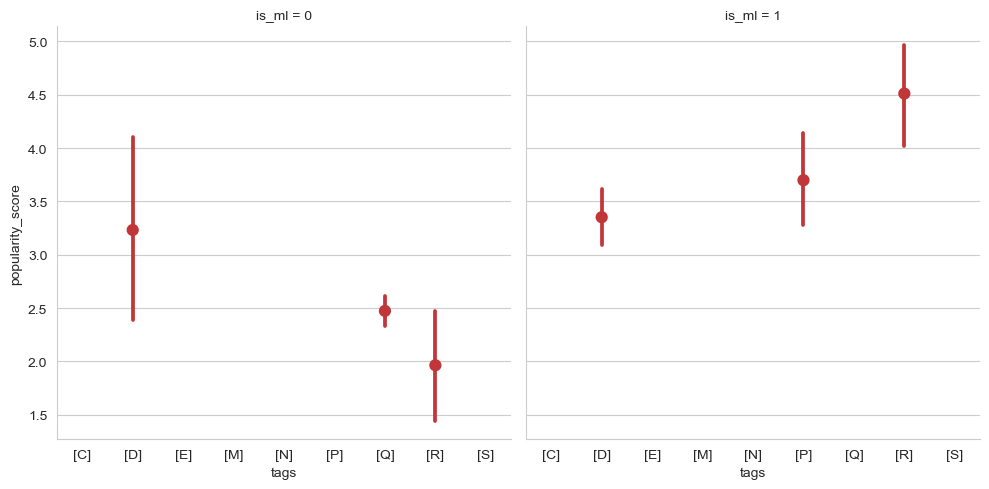

In [40]:
#Segregating popularity score distribution by subreddit
sns.catplot(data=df_tags, x='tags', y='popularity_score',kind='point', col='is_ml', join=False)


Questions posted on r/statistics are generally not as popular, as compared to posts with tags on projects and research that seem to be very popular. This makes sense considering all the AI hype nowadays, hence it is fair to conclude that topics revolving the shiniest AI models garner a lot of popularity nowadays, as we will see in the subsequent section.

<br><br>Next, we can explore on how the popularity of the subreddits changed over time

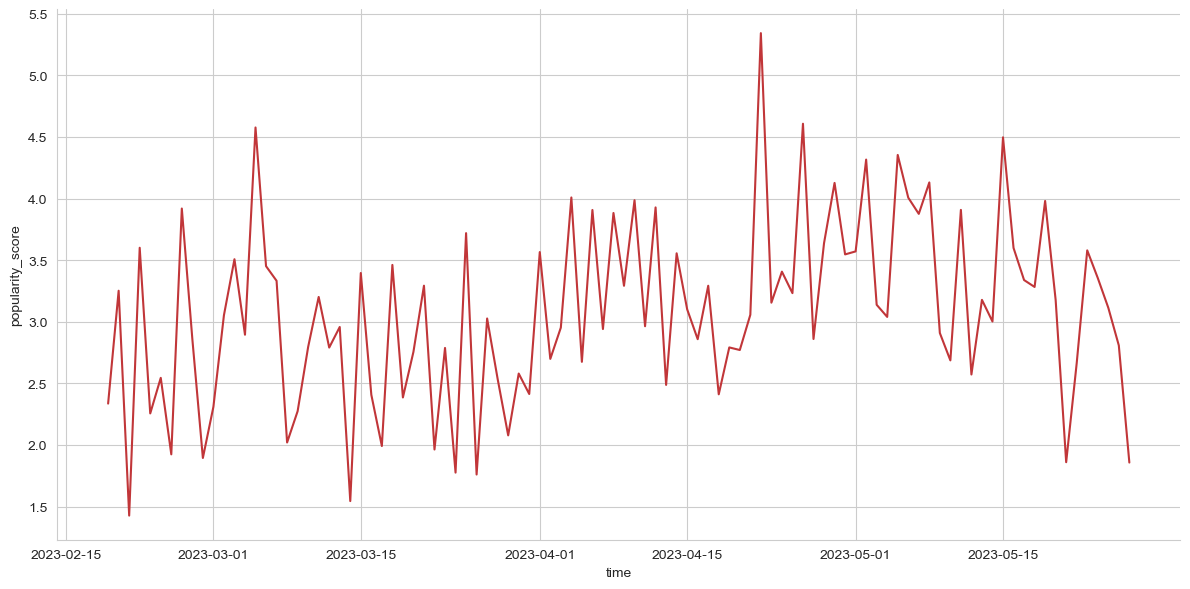

In [41]:
df_datetime = df.reset_index()
gb_date = df_datetime.groupby(pd.Grouper(key='time',freq='D'))['popularity_score'].mean().reset_index()


sns.relplot(data=gb_date, x='time', y='popularity_score', kind='line',height=6,aspect=2 )


Overall popularity doesnt seem to have changed much over time. Lets deep dive into popularities of each individual subreddit threads

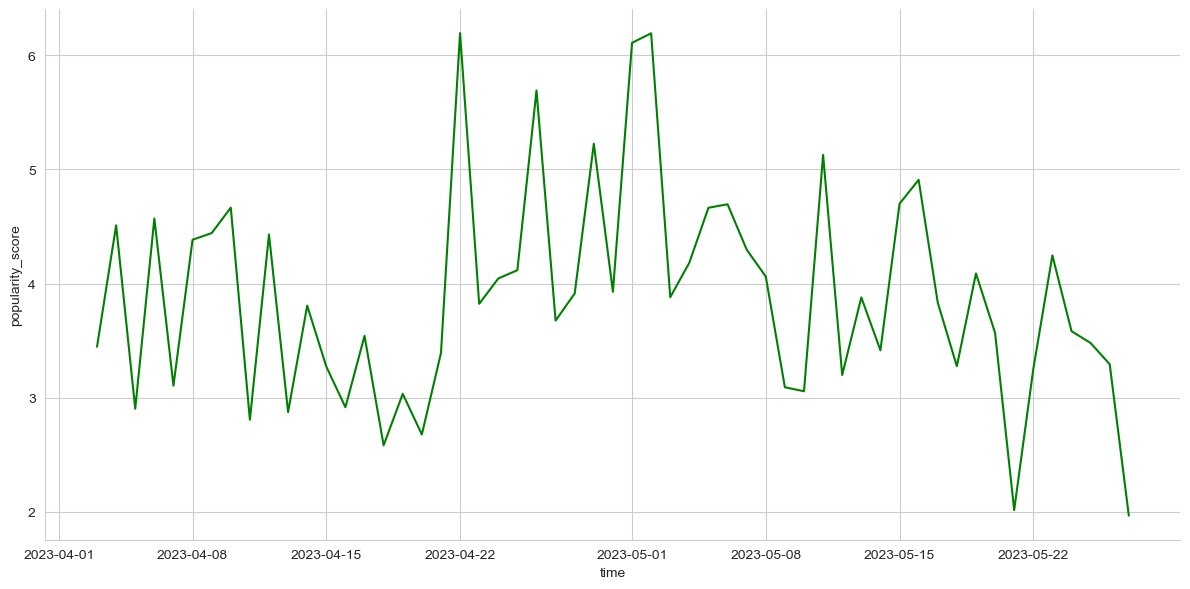

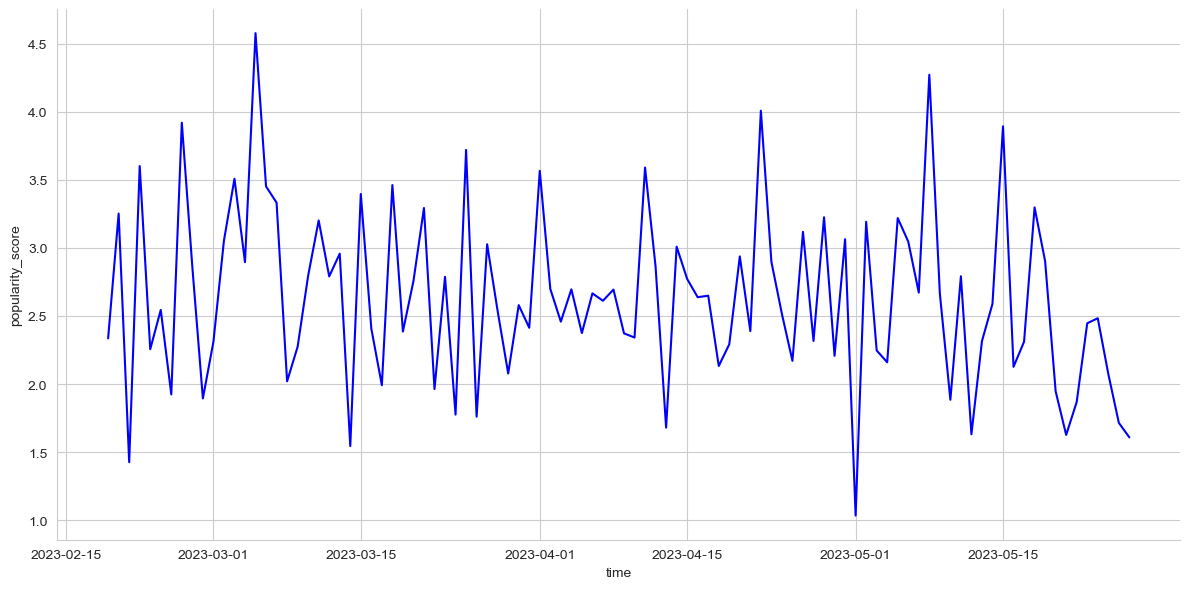

In [42]:
ml = df[df['is_ml']==1].reset_index()
stats = df[df['is_ml']==0].reset_index()

gb_date_ml = ml.groupby(pd.Grouper(key='time',freq='D'))['popularity_score'].mean().reset_index()
gb_date_stats = stats.groupby(pd.Grouper(key='time',freq='D'))['popularity_score'].mean().reset_index()


sns.relplot(data=gb_date_ml, x='time', y='popularity_score', kind='line',height=6,aspect=2, color='green')
sns.relplot(data=gb_date_stats, x='time', y='popularity_score', kind='line',height=6,aspect=2, color='blue')

plt.show()

Theres no conclusion we can draw from these 2 graphs, as the number of datapoints collected is possibly too small, and there is no obvious trend we can glean from the above 2 graphs

<br><br>Lets now explore how the number of upvotes and comments vary from different subreddit threads and tags

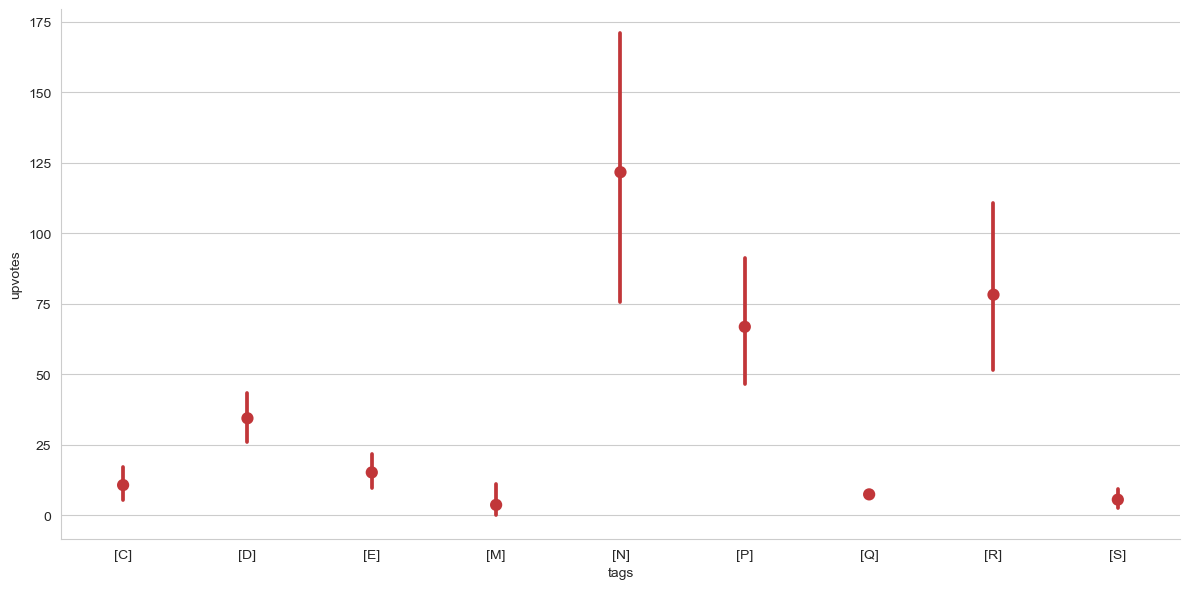

In [43]:
sns.catplot(data=df, x='tags', y='upvotes', kind='point', height=6, aspect=2, join=False)

From the above graph, News has the highest number of overall upvotes, followed by Research and Projects. <br>

As the y axis represents the mean number of upvotes, and [N] only has 58 entries in total, the mean number of upvotes could possibly have been overinflated. [P] and [R] on the other hand both have 218 posts each, and their high mean upvote score can be conclusively indicative of the popularity of such genre of threads in r/machinelearning, which further reinforces the pattern observed in the above section.<br>

These 3 tags are also mainly from the r/machinelearning subreddit thread, which is indicative of the liveliness in that subreddit thread due to the AI hype.

---

### Community Detection
We use KMeans clustering here to try to detect for posts with similar keywords mentioned

In [44]:
#Feature extraction using tf-idf
tfidf_title = TfidfVectorizer()

X_title = tfidf_title.fit_transform(df['tokenized_title'])



In [45]:
#Fitting for title and optimizing for best n_cluster value

inertia_title = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i,max_iter=500)
    kmeans.fit(X_title)
    inertia_title.append((i,kmeans.inertia_))

inertia_title

C:\Users\tanya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(1, 1966.6562834623655),
 (2, 1954.4776059473932),
 (3, 1944.7185057213378),
 (4, 1936.9465032807072),
 (5, 1928.9420069078283),
 (6, 1927.1517560923733),
 (7, 1919.1849522129066),
 (8, 1906.4172797939664),
 (9, 1903.9180237506914),
 (10, 1896.667750132219),
 (11, 1890.1828364739974),
 (12, 1886.2761018889234),
 (13, 1880.3836855629752),
 (14, 1871.1572499150375),
 (15, 1877.696191024037),
 (16, 1866.2786116353757),
 (17, 1864.2932398645548),
 (18, 1855.6881434817367),
 (19, 1855.2426412820107),
 (20, 1848.9987734039892),
 (21, 1841.9541864299329),
 (22, 1840.1517175457295),
 (23, 1836.6833899369308),
 (24, 1831.5939543401719),
 (25, 1831.3062483188758),
 (26, 1821.2202143304369),
 (27, 1823.7658109634149),
 (28, 1817.08962024713),
 (29, 1809.918114553268),
 (30, 1814.576420012201),
 (31, 1806.6554104312786),
 (32, 1808.9393383976976),
 (33, 1800.4461961917193),
 (34, 1799.077671590488),
 (35, 1793.6152970450241),
 (36, 1795.3206646646363),
 (37, 1795.6019168979321),
 (38, 1790.419010

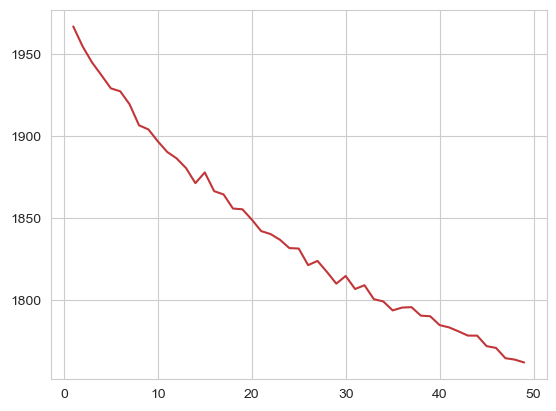

In [46]:
inertia_values = [tup[1] for tup in inertia_title]
plt.plot(range(1,50),inertia_values)
plt.show()


Seems like there is a small elbow point at n=37 - we will be using that

In [47]:

kmeans = KMeans(n_clusters=37,max_iter=500, random_state=42)
kmeans.fit(X_title)
df['title_cluster'] = kmeans.labels_
df.head()

,title,content,top_10_comments,upvotes,no_of_comments,url,tags,popularity_score,is_ml,tokenized_title,tokenized_content,tokenized_topcomments,title_cluster
time,,,,,,,,,,,,,
2023-05-27 15:46:09,Training and serving GPT-2 using Keras-CV and...,"Hi, just want to share my latest project in wh...",[],1,0,https://www.reddit.com/r/MachineLearning/comme...,[P],0.000000,1,training serving gpt2 kerascv tensorflow,hi want share latest project playing tensorflo...,nil,20
2023-05-27 13:09:54,Prediction of range,I’m using neural networks and tensor flow on p...,[],0,0,https://www.reddit.com/r/MachineLearning/comme...,[D],0.000000,1,prediction range,’ neural network tensor flow python library pr...,nil,20
2023-05-27 08:44:16,Learning Theory,I remember taking a class in college about sta...,['The Performer paper has some learning theory...,5,1,https://www.reddit.com/r/MachineLearning/comme...,[D],1.609438,1,learning theory,remember taking class college statistical lear...,performer paper learning theory theorem 2 just...,19
2023-05-27 07:49:25,Sophia: A Scalable Stochastic Second-order Op...,nil content,"['Wrong repo link, this one is official: https...",24,4,https://arxiv.org/abs/2305.14342,[R],4.564348,1,sophia scalable stochastic secondorder optimiz...,nil content,wrong repo link one official httpsgithubcomliu...,36
2023-05-27 07:12:33,Instruction following codegen model you can u...,Releasing https://huggingface.co/sahil2801/ins...,['What dataset does it use?'],2,1,https://www.reddit.com/r/MachineLearning/comme...,[P],0.693147,1,instruction following codegen model commercially,releasing httpshuggingfacecosahil2801instructc...,dataset,5


It seems like KMeans is able to sufficiently distinguish some threads from each other. Lets investigate a few selected clusters to see commonnalities in the threads

In [48]:
for i in range(37):
    if (df[df['title_cluster']==i].sort_values('title_cluster')['is_ml'].value_counts(normalize=True).max()>0.9) == True:
        print(f"Cluster {i}:")
        display(df[df['title_cluster']==i].sort_values('title_cluster')['is_ml'].value_counts())
        # Call the function to get the top keywords
        print("\n")



Cluster 2:


1    26
0     2
Name: is_ml, dtype: int64



Cluster 4:


0    41
1     1
Name: is_ml, dtype: int64



Cluster 6:


1    67
0     2
Name: is_ml, dtype: int64



Cluster 7:


0    27
1     1
Name: is_ml, dtype: int64



Cluster 8:


1    70
Name: is_ml, dtype: int64



Cluster 9:


1    42
0     1
Name: is_ml, dtype: int64



Cluster 10:


0    41
1     3
Name: is_ml, dtype: int64



Cluster 14:


0    34
1     1
Name: is_ml, dtype: int64



Cluster 17:


0    22
1     1
Name: is_ml, dtype: int64



Cluster 18:


1    33
0     2
Name: is_ml, dtype: int64



Cluster 21:


1    22
Name: is_ml, dtype: int64



Cluster 23:


0    22
Name: is_ml, dtype: int64



Cluster 28:


0    51
1     3
Name: is_ml, dtype: int64



Cluster 29:


0    45
Name: is_ml, dtype: int64



Cluster 30:


0    39
1     1
Name: is_ml, dtype: int64



Cluster 33:


1    27
Name: is_ml, dtype: int64



Cluster 35:


1    23
0     1
Name: is_ml, dtype: int64



Cluster 36:


1    53
Name: is_ml, dtype: int64

In [49]:
get_top_keywords(X_title, kmeans.labels_, tfidf_title.get_feature_names_out(), 10)


Cluster 0
criterion,paper,youtube,content,dataset,course,textbook,learn,book,recommendation

Cluster 1
graduate,applied,science,degree,good,bachelor,master,machine,learning,statistic

Cluster 2
field,train,radiance,suggestion,usage,metaanalysis,copyrighted,convolutional,neural,network

Cluster 3
diagramscausal,practitioner,guidance,start,survey,treatment,requires,control,inference,causal

Cluster 4
multiple,two,model,binary,random,linear,dependent,independent,regression,variable

Cluster 5
finetuning,risk,foundation,train,multilingual,forecasting,trained,llama,generative,model

Cluster 6
microsoft,think,building,multiple,regulation,advice,google,generative,voice,ai

Cluster 7
calculate,data,ii,matrix,explain,coefficient,type,someone,error,correlation

Cluster 8
tuning,app,ability,fine,like,source,hallucination,training,finetuning,llm

Cluster 9
gan,autoencoder,text,prompt,generation,captioning,classifier,segmentation,model,image

Cluster 10
time,mann,experiment,perform,compare,study,r

<br>

<br>For better visualisation, the following table shows the split of the clusters, along with the corresponding common words used (1 - from r/machinelearning, 0 - from r/statistics):

| **Cluster** | **Value Counts** | **Predominant Topic** | **Common Words**                                                                                |
|-------------|------------------|-----------------------|-------------------------------------------------------------------------------------------------|
| 4           | 0 - 41<br>1 - 1  | r/statistics          | multiple,two,model,binary,random,linear,dependent,independent,regression,variable               |
| 7           | 0 - 27<br>1 - 1  | r/statistics          | calculate,data,ii,matrix,explain,coefficient,type,someone,error,correlation                     |
| 10          | 0 - 41<br>1 - 3  | r/statistics          | time,mann,experiment,perform,compare,study,ratio,appropriate,statistical,test                   |
| 14          | 0 - 34<br>1 - 1  | r/statistics          | repeated,test,calculate,group,small,hypothesis,population,calculation,size,sample               |
| 17          | 0 - 22<br>1 - 1  | r/statistics          | generalisability,one,two,likelihood,calculating,block,surviving,time,equal,probability          |
| 23          | 0 - 22<br>1 - 0  | r/statistics          | tail,compare,unequal,interpret,nonnormal,skewed,two,mean,normal,distribution                    |
| 28          | 0 - 51<br>1 - 3  | r/statistics          | compare,analysis,poisson,binary,probit,model,coefficient,linear,logistic,regression             |
| 29          | 0 - 45<br>1 - 0  | r/statistics          | probability,person,dissertation,anyone,understanding,problem,study,stats,need,help              |
| 30          | 0 - 39<br>1 - 1  | r/statistics          | conduct,component,statistical,multiple,correspondence,post,costeffectiveness,hoc,power,analysis |
| 2           | 0 - 2<br>1 - 26  | r/machinelearning     | field,train,radiance,suggestion,usage,metaanalysis,copyrighted,convolutional,neural,network     |
| 6           | 0 - 2<br>1 - 67  | r/machinelearning     | microsoft,think,building,multiple,regulation,advice,google,generative,voice,ai                  |
| 8           | 0 - 0<br>1 - 70  | r/machinelearning     | tuning,app,ability,fine,like,source,hallucination,training,finetuning,llm                       |
| 9           | 0 - 1<br>1 - 42  | r/machinelearning     | gan,autoencoder,text,prompt,generation,captioning,classifier,segmentation,model,image           |
| 18          | 0 - 2<br>1 - 33  | r/machinelearning     | think,engineer,problem,project,concept,challenge,amazon,learn,hackathon,ml                      |
| 21          | 0 - 0<br>1 - 22  | r/machinelearning     | llm,microsoft,song,cost,brave,cofounder,research,chatgpt,new,gpt4                               |
| 33          | 0 - 0<br>1 - 27  | r/machinelearning     | dashboard,embeddings,else,source,ai,3d,shape,model,api,openai                                   |
| 35          | 0 - 1<br>1 - 23  | r/machinelearning     | synthesizer,singing,eterministic,texttoimage,generative,survey,latent,stable,model,diffusion    |
| 36          | 0 - 0<br>1 - 53  | r/machinelearning     | finetuning,computer,tuning,state,new,reasoning,instruction,large,model,language                 |

From the above, there are several insights we can see: <br><br>

r/statistics:
- Discussions tend to revolve around fundamental statistics concepts (keywords like distribution, mean, poisson, regression, logistic/linear in clusters 4, 23, 28), statistical tests (keywords such as experiment, study, ratio, and test in cluster 10) and data interpretation (keywords such as power, correspondence etc in cluster 30). 
- There is also a chunk of posts revolving queries with keywords like dissertation, understanding etc

r/machinelearning:
- Discussions revolve around advanced machine learning concepts and applications (keywords like "convolutional", "neural" and "network", "llm", "gan", "embeddings", "diffusion" in clusters 2, 8, 9, 33 and 35)
- There's also a strong representation of industry-related topics, as indicated by mentions of tech companies (Microsoft, Amazon, Google), as well as discussion around more practical elements of implementing ML systems (building, project, challenge, hackathon). This reflects the subreddit's focus on advanced ML techniques, practical implementation, and industry trends.


In summary, while there is an overlap in interests around data, modelling, and analysis, the two subreddits have distinctive focuses. r/statistics seems more oriented towards understanding and correctly applying statistical principles and methods, often in academic or research contexts. On the other hand, r/machinelearning is more focused on advanced machine learning techniques, practical implementation, emerging technologies, and industry trends.

<br><br> Exploring the remainder of the clusters that have a more equal spread of r/statistics and r/machinelearning posts

In [50]:
for i in range(26):
    if (df[df['title_cluster']==i].sort_values('title_cluster')['is_ml'].value_counts(normalize=True).max()<0.6)== True:
        print(f"Cluster {i}:")
        display(df[df['title_cluster']==i].sort_values('title_cluster')['is_ml'].value_counts())
        # Call the function to get the top keywords
        print("\n")

Cluster 15:


1    9
0    8
Name: is_ml, dtype: int64



Cluster 19:


1    27
0    23
Name: is_ml, dtype: int64



Cluster 20:


1    317
0    289
Name: is_ml, dtype: int64

The following table shows the clusters that have a more equal spread of r/statistics vs r/machinelearning, along with the corresponding common words used (1 - from r/machinelearning, 0 - from r/statistics):

| **Cluster** | **Value Counts**   | **Common Words**                                                                            |
|-------------|--------------------|---------------------------------------------------------------------------------------------|
| 0           | 0 - 399<br>1 - 350   | criterion,paper,youtube,content,dataset,course,textbook,learn,book,recommendation |



It appears that both subreddits, r/statistics and r/machinelearning, share a common interest in learning resources and content sharing. The discussions in this cluster seem to be focused on seeking and providing recommendations for learning materials and datasets.

The common words - 'criterion', 'paper', 'youtube', 'content', 'dataset', 'course', 'textbook', 'learn', 'book', 'recommendation' - suggest discussions around educational content, which could include sharing and requesting recommendations for textbooks ('textbook', 'book'), online courses ('course'), research papers ('paper'), and instructional videos ('youtube').

The word 'dataset' indicates that users in both communities are discussing and sharing sources of data for learning, practicing, or research purposes. The words 'criterion' and 'recommendation' further support this notion of seeking or providing advice, possibly in terms of selecting resources or datasets.

In [51]:
#Filtering out rows with nil content
df_temp = df[df['content']!='nil content']

In [52]:
#Exploring content


tfidf_content = TfidfVectorizer()

X_content = tfidf_content.fit_transform(df_temp['tokenized_content'])

In [53]:
#Fitting for content and optimizing for best n_cluster value

inertia_content = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i,max_iter=500)
    kmeans.fit(X_content)
    inertia_content.append((i,kmeans.inertia_))

inertia_content

C:\Users\tanya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(1, 1798.2393672482397),
 (2, 1789.2486797169354),
 (3, 1781.175755028643),
 (4, 1775.015734155),
 (5, 1769.8435834392872),
 (6, 1765.7667135726927),
 (7, 1762.452127912036),
 (8, 1759.7329681269184),
 (9, 1757.9811657525488),
 (10, 1753.9190473733054),
 (11, 1750.7925007963577),
 (12, 1748.1102849470262),
 (13, 1746.9329958917658),
 (14, 1745.112816156249),
 (15, 1742.5864511515429),
 (16, 1738.707326150048),
 (17, 1736.5836567544034),
 (18, 1734.084980557759),
 (19, 1733.2012255696723),
 (20, 1731.1974238407452),
 (21, 1729.401344765854),
 (22, 1726.7350206224346),
 (23, 1725.9883440549063),
 (24, 1724.2891083607144),
 (25, 1721.8704199442045),
 (26, 1719.6739775452395),
 (27, 1718.5829328816067),
 (28, 1714.73042222776),
 (29, 1712.9414041952084),
 (30, 1711.4896055110748),
 (31, 1709.5783753175162),
 (32, 1709.875665443179),
 (33, 1708.1280096653259),
 (34, 1709.9569223783874),
 (35, 1704.5880280528029),
 (36, 1701.8129761612604),
 (37, 1700.826554023409),
 (38, 1699.9226563034595

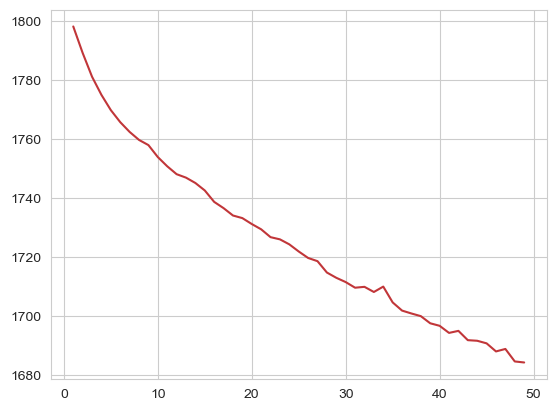

In [54]:
inertia_values = [tup[1] for tup in inertia_content]
plt.plot(range(1,50),inertia_values)
plt.show()

We will pick n=36 which sppears to be a small elbow point

In [55]:
kmeans_content = KMeans(n_clusters=36,max_iter=500, random_state=42)
kmeans_content.fit(X_content)
df_temp['content_cluster'] = kmeans_content.labels_
df.head()

C:\Users\tanya\AppData\Local\Temp\ipykernel_1520\4104805272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['content_cluster'] = kmeans_content.labels_


,title,content,top_10_comments,upvotes,no_of_comments,url,tags,popularity_score,is_ml,tokenized_title,tokenized_content,tokenized_topcomments,title_cluster
time,,,,,,,,,,,,,
2023-05-27 15:46:09,Training and serving GPT-2 using Keras-CV and...,"Hi, just want to share my latest project in wh...",[],1,0,https://www.reddit.com/r/MachineLearning/comme...,[P],0.000000,1,training serving gpt2 kerascv tensorflow,hi want share latest project playing tensorflo...,nil,20
2023-05-27 13:09:54,Prediction of range,I’m using neural networks and tensor flow on p...,[],0,0,https://www.reddit.com/r/MachineLearning/comme...,[D],0.000000,1,prediction range,’ neural network tensor flow python library pr...,nil,20
2023-05-27 08:44:16,Learning Theory,I remember taking a class in college about sta...,['The Performer paper has some learning theory...,5,1,https://www.reddit.com/r/MachineLearning/comme...,[D],1.609438,1,learning theory,remember taking class college statistical lear...,performer paper learning theory theorem 2 just...,19
2023-05-27 07:49:25,Sophia: A Scalable Stochastic Second-order Op...,nil content,"['Wrong repo link, this one is official: https...",24,4,https://arxiv.org/abs/2305.14342,[R],4.564348,1,sophia scalable stochastic secondorder optimiz...,nil content,wrong repo link one official httpsgithubcomliu...,36
2023-05-27 07:12:33,Instruction following codegen model you can u...,Releasing https://huggingface.co/sahil2801/ins...,['What dataset does it use?'],2,1,https://www.reddit.com/r/MachineLearning/comme...,[P],0.693147,1,instruction following codegen model commercially,releasing httpshuggingfacecosahil2801instructc...,dataset,5


In [56]:
get_top_keywords(X_content, kmeans_content.labels_, tfidf_content.get_feature_names_out(), 10)


Cluster 0
day,time,24,hour,forecast,month,price,data,forecasting,sale

Cluster 1
way,correlation,matrix,possible,grid,one,set,search,parameter,value

Cluster 2
grad,year,school,course,algebra,class,im,statistic,stats,math

Cluster 3
stay,wwwdatasmithclickhttpswwwdatasmithclick,alive,instead,new,question,check,feedback,post,thread

Cluster 4
sample,data,test,concentration,group,control,spss,treatment,different,anova

Cluster 5
yet,project,token,text,model,gpt4,code,api,openai,prompt

Cluster 6
row,segmentation,zeroshot,distance,feature,instance,model,measurement,datasets,x200b

Cluster 7
one,language,dataset,question,user,could,task,like,model,llm

Cluster 8
research,paper,chatgpt,ai,state,diffusion,llama,language,generative,model

Cluster 9
value,standard,error,disease,variance,mean,population,size,deviation,sample

Cluster 10
im,point,every,average,feature,week,value,observation,player,game

Cluster 11
help,ive,python,fit,type,line,best,get,anyone,factor

Cluster 12
architecture,one,

In [57]:
for i in range(36):
    if (df_temp[df_temp['content_cluster']==i].sort_values('content_cluster')['is_ml'].value_counts(normalize=True).max()>0.9)== True:
        print(f"Cluster {i}:")
        display(df_temp[df_temp['content_cluster']==i].sort_values('content_cluster')['is_ml'].value_counts())
        # Call the function to get the top keywords
        print("\n")

Cluster 2:


0    49
1     2
Name: is_ml, dtype: int64



Cluster 4:


0    26
Name: is_ml, dtype: int64



Cluster 5:


1    36
0     3
Name: is_ml, dtype: int64



Cluster 7:


1    71
Name: is_ml, dtype: int64



Cluster 8:


1    52
0     4
Name: is_ml, dtype: int64



Cluster 9:


0    41
1     2
Name: is_ml, dtype: int64



Cluster 12:


1    79
0     8
Name: is_ml, dtype: int64



Cluster 13:


0    21
Name: is_ml, dtype: int64



Cluster 14:


0    43
1     3
Name: is_ml, dtype: int64



Cluster 15:


0    49
1     5
Name: is_ml, dtype: int64



Cluster 17:


0    20
Name: is_ml, dtype: int64



Cluster 18:


1    36
0     1
Name: is_ml, dtype: int64



Cluster 26:


0    31
1     1
Name: is_ml, dtype: int64



Cluster 29:


0    62
1     1
Name: is_ml, dtype: int64



Cluster 31:


1    29
0     3
Name: is_ml, dtype: int64



Cluster 32:


0    15
Name: is_ml, dtype: int64



Cluster 33:


0    32
1     2
Name: is_ml, dtype: int64



Cluster 34:


0    27
1     1
Name: is_ml, dtype: int64

The following table shows the clusters that have a more distinct spread of r/statistics vs r/machinelearning, along with the corresponding common words used (1 - from r/machinelearning, 0 - from r/statistics):

| **Cluster** | **Value Counts** | **Predominant Topic** | **Common Words**                                                                        |
|-------------|------------------|-----------------------|-----------------------------------------------------------------------------------------|
| 2           | 0 - 49<br>1 - 2  | r/statistics          | grad,year,school,course,algebra,class,im,statistic,stats,math                           |
| 4           | 0 - 26<br>1- 0   | r/statistics          | sample,data,test,concentration,group,control,spss,treatment,different,anova             |
| 9           | 0 - 41<br>1 - 0  | r/statistics          | value,standard,error,disease,variance,mean,population,size,deviation,sample             |
| 13          | 0 - 21           | r/statistics          | test,speed,list,analysis,mediation,two,relationship,dependent,independent,variable      |
| 14          | 0 - 43<br>1 - 3  | r/statistics          | effect,data,hi,linear,categorical,analysis,dataset,regression,model,variable            |
| 15          | 0 - 49<br>1 - 5  | r/statistics          | skewed,time,data,one,probability,sample,mean,value,normal,distribution                  |
| 17          | 0 - 20<br>1 - 0  | r/statistics          | jamovi,question,function,wilcoxon,answer,differenced,welchs,student,interval,confidence |
| 26          | 0 - 31<br>1 - 1  | r/statistics          | mean,table,reject,test,hypothesis,variable,change,null,cell,survival                    |
| 29          | 0 - 62<br>1 - 1  | r/statistics          | appropriate,anova,significant,im,variable,ttest,data,sample,group,test                  |
| 32          | 0 - 15<br>1 - 0  | r/statistics          | costeffectiveness,two,analysis,randomized,cea,effect,conduct,itc,trial,treatment        |
| 33          | 0 - 32<br>1 - 2  | r/statistics          | green,one,anova,marble,compare,test,box,red,subject,group                               |
| 34          | 0 - 27<br>1 - 1  | r/statistics          | control,education,covariate,data,comparison,year,variable,effect,salary,age             |
| 5           | 0 - 3<br>1 - 36  | r/machinelearning     | yet,project,token,text,model,gpt4,code,api,openai,prompt                                |
| 7           | 0 - 0<br>1 - 71  | r/machinelearning     | one,language,dataset,question,user,could,task,like,model,llm                            |
| 8           | 0 - 4<br>1 - 52  | r/machinelearning     | research,paper,chatgpt,ai,state,diffusion,llama,language,generative,model               |
| 12          | 0 - 8<br>1 - 79  | r/machinelearning     | architecture,one,ml,new,like,dataset,data,train,training,model                          |
| 18          | 0 - 1<br>1 - 36  | r/machinelearning     | text,like,segmentation,similarity,network,input,output,task,model,image                 |
| 31          | 0 - 3<br>1 - 29  | r/machinelearning     | link,post,text,code,window,transformer,model,finetuning,context,token                   |

Similar to the titles column, the discussions in r/statistics seem to focus much on traditional statistical methods and testing methodologies, while r/machinelearning seem to focus on practical aspects and applications of machine learning.

In [58]:
for i in range(26):
    if (df_temp[df_temp['content_cluster']==i].sort_values('content_cluster')['is_ml'].value_counts(normalize=True).max()<0.6)== True:
        print(f"Cluster {i}:")
        display(df_temp[df_temp['content_cluster']==i].sort_values('content_cluster')['is_ml'].value_counts())
        # Call the function to get the top keywords
        print("\n")

Cluster 24:


1    22
0    15
Name: is_ml, dtype: int64

There are only three clusters (ie clusters 3, 10 and 14) with an equal spread of labels, and the top 10 common words are:

<b>Cluster 3: </b>stay,alive,instead,new,question,check,feedback,post,thread<br>
<b>Cluster 10: </b>im,point,every,average,feature,week,value,observation,player,game<br>
<b>Cluster 14: </b>effect,data,hi,linear,categorical,analysis,dataset,regression,model,variable<br>

From these clusters, it appears that there are some common themes shared between the r/statistics and r/machinelearning subreddits.

Cluster 3: This cluster seems to capture the interactive and participative nature of subreddit discussions. Words like "stay", "alive", "instead", "new", "question", "check", "feedback", "post", "thread" suggest discussions, questions, and requests for feedback or help, which are common to both subreddits. It is indicative of the nature of subreddit communities where individuals share resources, seek feedback, and engage in dialogue.

Cluster 10: The terms in this cluster like "im", "point", "every", "average", "feature", "week", "value", "observation", "player", "game" suggest conversations around data collection, feature analysis, and possibly real-world applications like game analytics. Both r/statistics and r/machinelearning involve dealing with features (variables) in datasets and making observations, so it's not surprising to see this overlap.

Cluster 14: This cluster appears to encapsulate discussions around data modeling and analysis. Words such as "effect", "data", "hi", "linear", "categorical", "analysis", "dataset", "regression", "model", "variable" are central to both statistics and machine learning. Both communities will have discussions around data analysis, regression models, the effect of variables, and dealing with different kinds of data (e.g., categorical).

In summary, it seems that both r/statistics and r/machinelearning subreddits share similarities in terms of interaction patterns, focus on data and feature analysis, and discussions around modeling and regression.

<br><br>With the above findings, we can see that there are several clusters with distinct domination of either r/statistics or r/machinelearning posts, with common keywords present in each cluster. This validates the practicality of building a classifier (in the next section) to predict whether posts belong to r/statistics or r/machinelearning.<br><br>

We can also see distinct topics/communities present from the keywords in each cluster, which we will discuss further in detail in the [conclusion](#Conclusions-&-Findings).

---

<br>
<br>

<br><br>

# Text Classification

We will be training the model using the following features in different phases to see if theres any difference to the accuracy scores (p represents phase): 
- upvotes (p3)
- no_of_comments (p3)
- tags (p2)
- tokenized_title (p1)
- tokenized_content (p1)
- tokenized_topcomments (p1)

So for instance, in phase 1, we will be training the models solely based on the tokenized title, content and comments only, followed by phase 2 where we will add in the tags and retrain the model and assess its accuracy, before finally adding in the upvotes and number of comments.

### Preprocessing (p1)

First, we need to generate X with the above stated features. The purpose of this section will be to sieve out words in the corpus that does not value add to the model, and add them to our custom list of stop_words. The process involves fitting the count vectorizer, after which, we will visualize the top 20 words found in the corpus, and evaluate if these words provide any useful info in helping the model predict whether the post belongs to r/machinelearning or r/statistics. If the word is not useful (eg words like want, need, like, think, dont etc), we add them to our custom list of stop_words.

In [59]:
#We customize our own set of stop words here to remove less meaningful words

additional_stop_words = ['way','work','im','want','need','like','think','dont','mean','make','good','question','people','thing','used','example','number']
stop_words = list(CountVectorizer(stop_words='english').get_stop_words())+additional_stop_words



In [60]:
#Concatenating tokenized_title, tokenized_content and tokenized_topcomments, then extracting the top 20 words from tokenized_title, tokenized_content and tokenized_topcomments
X = df['tokenized_title'] + ' ' + df['tokenized_content'] + ' ' + df['tokenized_topcomments']

y=df['is_ml']


print(type(X))
print(X.shape, y.shape)


<class 'pandas.core.series.Series'>
(1979,) (1979,)


In [61]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, \nX_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1583,), y_train shape: (1583,), 
X_test shape: (396,), y_test shape: (396,)


In [62]:
#Using cvec to vectorize columns

cvec_X = CountVectorizer(stop_words=stop_words)
cvec_X.fit(X_train)

CountVectorizer(stop_words=['and', 'thin', 'her', 'few', 'seeming', 'un',
                            'above', 'here', 'co', 'himself', 'sincere', 'him',
                            'fifty', 'full', 'someone', 'see', 'along',
                            'whither', 'whereas', 'serious', 'beforehand',
                            'must', 'could', 'latter', 'still', 'meanwhile',
                            'well', 'sometimes', 'whether', 'mill', ...])

In [63]:
#Transforming X_train and X_test into tfidf matrices
X_train_cvec = cvec_X.transform(X_train)
X_test_cvec = cvec_X.transform(X_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, \nX_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

#Converting tfidf sparse matrices into dataframes
X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec_X.get_feature_names_out())
X_test_cvec_df = pd.DataFrame(X_test_cvec.todense(), columns=cvec_X.get_feature_names_out())


X_train shape: (1583,), y_train shape: (1583,), 
X_test shape: (396,), y_test shape: (396,)


<Axes: >

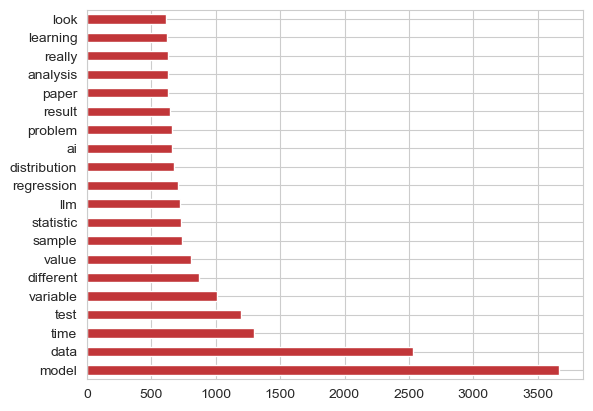

In [64]:
X_train_cvec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')

---

### Modelling (p1)

The next section will aim to train 6 models -  Logistic Regression, Decision Tree, Random Forest, GradientBoostingClassifier, AdaBoostClassifier and SVM models to classify whether a post belongs to r/machinelearning or r/statistics. We will be using the Pipeline object to vectorize X_train and then train and predict using the 4 different models.

We use TfidfVectorizer here instead of CountVectorizer because not all keywords hold equal importance in the corpus. For instance, the word 'statistic' may hold very significant importance in helping the model classify the post to be under r/statistics, as compared to the word 'data' which appears in both subreddits and is not as important in helping the model.<br><br>

Also, we will be evaluating the model's performance using the confusion matrix (since it is a classification problem), and also using GridSearchCV's best_scores_ attribute.

In [65]:
#Creating the pipeline object
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('classifier', LogisticRegression(random_state=42))
])



In [66]:
#Defining the parameter grids for each model

parameter_grids = [

    {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty':[None,'l1','l2'],
        'classifier__solver':['lbfgs','liblinear'],
    },
    {
        'classifier': [SVC(random_state=42)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf', 'poly']
    },
    
        {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 20]
    },
    
       {
        'classifier': [AdaBoostClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    },
    
      {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    }
]

In [67]:
# #Commenting out the following code  -results of the gridsearch have been appended in table below

# #Resetting sns gridstyle
# sns.set_style("white")

# #Ignoring warnings

# warnings.filterwarnings('ignore')


# # Perform grid search for each model
# for parameter_grid in parameter_grids:
#     grid_search = GridSearchCV(pipeline, parameter_grid, cv=5)
#     grid_search.fit(X_train, y_train)
    
#     # Print the best parameters and the classification report
#     print("Best parameters:", grid_search.best_params_)
#     y_pred = grid_search.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
#     print(grid_search.best_score_)
#     print(grid_search.best_estimator_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
#     disp.plot()
#     plt.show()
#     print("---------------------------------------")
    
# warnings.filterwarnings("default")

The following are the best scores and estimators of the 6 models:

| **Model**               | **Best Score** | **Best Estimator**                                                            |
|-------------------------|----------------|-------------------------------------------------------------------------------|
| LogisticRegression      | 0.960          | LogisticRegression(C=0.1, penalty=None, random_state=42)                      |
| SVC                     | 0.958          | SVC(C=10.0, kernel='linear', random_state=42)                                 |
| DecisionTreeClassifier  | 0.871          | DecisionTreeClassifier(max_depth=20, random_state=42)                         |
| RandomForestClassifier  | 0.958          | RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)       |
| AdaBoostClassifier      | 0.950          | AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=42)      |
| GradientBoostClassifier | 0.948          | GradientBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42) |

<br>Most of the models except for DecisionTreeClassifier performs very well, with the best performer being LogisticRegression.

---

### Preprocessing (p2)

In [68]:
#OHE categorical columns

X_cat = OHE_catcolumn(df,col='tags')
X_cat

,[D],[E],[M],[N],[P],[Q],[R],[S]
time,,,,,,,,
2023-05-27 15:46:09,0,0,0,0,1,0,0,0
2023-05-27 13:09:54,1,0,0,0,0,0,0,0
2023-05-27 08:44:16,1,0,0,0,0,0,0,0
2023-05-27 07:49:25,0,0,0,0,0,0,1,0
2023-05-27 07:12:33,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2023-02-19 13:24:31,0,0,0,0,0,1,0,0
2023-02-19 12:42:36,0,0,0,0,0,1,0,0
2023-02-19 11:37:01,0,0,0,0,0,1,0,0


In [69]:
X_train

time
2023-02-26 03:17:19    hidden markov model implementation r python di...
2023-04-19 17:40:55    introducing ferret new python package streamli...
2023-05-11 00:33:13    legal navigation finetuning llm openai model o...
2023-03-14 19:54:07    calculating distance two variable correlation ...
2023-03-10 00:44:25    r package perform group lasso fit conditional ...
                                             ...                        
2023-03-21 00:16:57    pareto scaling anyone explain group mean oppos...
2023-04-15 10:41:39    web llm seeing amazing progress generative ai ...
2023-05-15 01:19:57    imagebind — holistic ai learning across six mo...
2023-04-14 05:28:43    recommendation screeningoptimization design bo...
2023-04-30 15:10:41    handle large resolution vision transformer hel...
Length: 1583, dtype: string

In [70]:
tfidf_X = TfidfVectorizer(stop_words=stop_words)

tfidf_X.fit(X_train)

X_train_tfidf = tfidf_X.transform(X_train)
X_test_tfidf = tfidf_X.transform(X_test)

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.todense(), columns=tfidf_X.get_feature_names_out(), index=X_train.index)
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.todense(), columns=tfidf_X.get_feature_names_out(), index=X_test.index)
X_train_tfidf_df

,00,000,0000,00000,0000000000,000000057nn2,0000005,0000061,000006gbhr,0000102579999nn,000010258,000011gbhr,00002,0000239nnthis,0000277,00003,00006427,000083,00009059n,0001,00010,000102579999,000111,0001777n,0001861118,0001nnfor,0002,000224,0002nnis,000315,00040xt7,00046xt2,0005,000504,000610351,000797,00081,0008412075,000877193nnit,001,00109,00113,00116,0012,0012ab,0014,00150,001876363,0019,0019hour,001nnthe,001request,002,00206xt3,0025,0026,002915,003,00303xt4,0031746,003174600634920031746,0031746nnif,00357,004,00476,0048,0049,00495nnnot,005,0051,005152553,0052,0053,00530016,00532xt5,00537xt6,00547,00555,00556,0056,005nnhowever,005nttnumsignificant,00625,0063492,0063492nnif,0068,007,00705,0074,007433852,0083,009,0093,0096,00httpswwweyeonannapolisnetwpcontentuploads202202image12jpg,00s,01,010,0100,01000,0101010101010101010101,0102,012,01210039500005200001,0125,013,0130,013157895,015,016,0162,0162nnthe,0171,0181,01nna,01nnis,02,020,0200,020c,021,02155,021554,023333,024,025,0265,0265133301,02778,027hour,027nnc,0285,029hr,02jan2023,02y,03,030,0300700,0307000,0315,0321,033,0333,033nnthe,033t60n,033y60,033z60,0358887800,0359494450,0363445459,0387,03897345,0399122807017544nnandnn,039912281,03jan2023,04,0402,0407535567,04075xt1,043,045,0460526315789474nnetc,046052632,048,0499657,04jan2023,04ntodds,05,0501httpsdocsgooglecomspreadsheetsd1jyh4pxnzmna9i0ym2epgra7vxbieigs64gpjbg5nhaedituspsharing,0512116,051hour,052,054,05494et1,0565,05750nnor,0578721600,059,05910749,05nn,05nnjust,05nnn,05nnthe,05x05x05,05y,05ynnallowing,06,06000800,060824cfa6545fb4cfe78bfd23b069010db0b5c6,0611,0612,06164414,06403124nn1,06415,065,065nnif,067,067nnthere,0693,0699,07,075,075x045x03,076,08,0804,0805,081,082,083,085,0898735800,08h,08ntprobability,09,091,09103642nnnwhere,092,0927,0927n,0940688359,09415,095,09520,095nnyou,097,098,099,0995,0996,09983339,09jan2023,09nnif,09yi,0n,0n6,0nn,0nnand,0nnbut,0nngives,0nngivesnn,0nnif,0nnis,0nnonce,0nnone,0nnt,0nnthat,0nnthennn0,0nnx200bnnsecond,0shot,...,yannic,yardstick,yardsticknnno,yaron,yastaa,yates,yatzy,yaxis,yay,ycbindti,ydetrend,yea,yeaer,yeah,year,yearend,yearlong,yearly,yearnnit,yearnnthis,yearsnni,yearsnnno,yearsnnwhat,yearsold,yelling,yellow,yemxb,yeoh,yep,yeras,yerror3e3,yervant,yes,yes235,yesdisease,yesnit,yesnn4,yesnnjeffreys,yesnnmuch,yesnnthe,yesnnwhy,yesno,yesnounknown,yessometimesnonnthe,yesterday,yetnna,yetnnand,yetnnanecdotally,yetnni,yetnnlink,yetnnwe,yetnnweve,yetnnwhen,yetnnwhy,yevent1,yfuture,yfx,yhat,yhati,yhatimxib,yi,yield,yielded,yielding,yikes,yintercept,ymmv,ymmvnndta,ymmw,ymodelnew,ymu,ymu2nnsorry,ymx2b,ymxb,ymxkz,yn,ynnnow,ynnwtfnnthe,ynnyour,ynormaltheta1,yo,yoda,yoe,yohel,yolo,yolohttpshuggingfacecospaceskadirnaryolov8,yolos,yonny,yordan,york,yoshua,youd,youll,young,younger,youngoldnnin,younn,younn3,younnand,younnbeware,younnbut,younndo,younnfirst,younnfor,younnhttpsoptimalscalegithubiolmflowexamplestaskguidehtml,younni,younnregarding,younnyoure,younrechardpeter09gmailcom,yourdownloadedmodelpth,youre,yourselfhttpsbotcotokenmonsterhtml,yourselfnnbe,yourwidth,youselected,youtube,youtubehttpswwwyoutubecomwatchv7r5ef69sfpe,youtubehttpswwwyoutubecomwatchv86nivrglr3y,youtubehttpsyoutubedfvwai1hnc,youtuber,youtubers,youtubes,youve,ypred,yr,yt,yt1,ytd12,ytheta1theta2,ytrue,yu,yuck,yucky,yuh,yujia,yup,yuppers,yuri,yuv,yuzhe,yvalues,yx,yx3,yxtheta2,yᵢ,y₁,y₂,yₙ,yₙnnthat,z0975,z1,z10,z2,z20,z21,z3,z30,z31,zab,zach,zag,zaheer,zalpha,zalphasqrthatp1hatpnnn2,zambon,zaremba,zcrit,zcritical,zebra,zelda,zeras,zero,zerodependency,zerodivision0,zeroed,zerofew,zerofewshot,zeroinflated,zeronnfor,zeronnwe,zeroshot,zeroshotnnits,zerosum,zeta,zettabyte,zhou,zi,zicklein,zig,zinb,zinc,zip,zipcode,zipf,zipnerf,zixuan,ziyu,zn,znnthe,znormal01,zobel,zold,zone,zonennhttpspubsacsorgcms101021acsjcim2c00562assetimagesmediumci2c005620008gifnni,zoom,zoomed,zoomedin,zoomposium,zpo,zpo24,zpower2,zpredzresid,zrkv,zrkvloadcontexthello,zrkvloadmodelpathtomodelbin,zrkvloadtokenizerpathtofolderwithvocab,zscore,zscores,zsolnaifeh

In [71]:
print(X_train.shape)

X_train_p2 = X_train_tfidf_df.merge(X_cat, left_index=True, right_index=True, how='left')
X_test_p2 = X_test_tfidf_df.merge(X_cat, left_index=True, right_index=True, how='left')

print(X_train_p2.shape)
print(X_test_p2.shape)

(1583,)
(1583, 28503)
(396, 28503)


---

### Modelling (p2)

Next, we train the 6 models again on this new X_train and X_test

In [72]:
pipeline_p2 = Pipeline([
   ('classifier', LogisticRegression(random_state=42))
])




In [73]:
# #Resetting sns gridstyle
# sns.set_style("white")

# #Ignoring warnings

# warnings.filterwarnings('ignore')


# # Perform grid search for each model
# for parameter_grid in parameter_grids:
#     grid_search = GridSearchCV(pipeline_p2, parameter_grid, cv=5)
#     grid_search.fit(X_train_p2, y_train)
    
#     # Print the best parameters and the classification report
#     print("Best parameters:", grid_search.best_params_)
#     y_pred = grid_search.predict(X_test_p2)
#     cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
#     print(grid_search.best_score_)
#     print(grid_search.best_estimator_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
#     disp.plot()
#     plt.show()
#     print("---------------------------------------")
    
# warnings.filterwarnings("default")

The following are the best scores and estimators of the 6 models:

| **Model**               | **Best Score** | **Best Estimator**                                                                               |
|-------------------------|----------------|--------------------------------------------------------------------------------------------------|
| LogisticRegression      | 0.982          | LogisticRegression(C=0.1, penalty=None, solver = 'lbfgs', random_state=42)                       |
| SVC                     | 0.980          | SVC(C=10.0, kernel='linear', random_state=42)                                                    |
| DecisionTreeClassifier  | 0.964          | DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf = 1, random_state=42) |
| RandomForestClassifier  | 0.977          | RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)                        |
| AdaBoostClassifier      | 0.980          | AdaBoostClassifier(n_estimators=300, learning_rate = 1,0, random_state=42)                       |
| GradientBoostClassifier | 0.968          | GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, random_state=42)               |

Across the board, model performances generally improved. DecisionTreeClassifier still performed the worst amongst the 6 models, together with GradientBoostClassifier, however given that the test set only has 300+ datapoints, these minute differences in percentage points may not be very significant in assessing model performances.

---

## Preprocessing (p3)

Finally, we append upvotes and no_of_comments. From p2, adding in the tags column improved the performances of the model, hence there is merit in believing that adding upvotes and no_of_comments will potentially improve the models' performances. 


In [74]:
#Subsetting a dataframe with columns upvotes and no_of_comments
df_tobemerged = df[['upvotes','no_of_comments']]

#Checking X_train_p2 and X_test_p2 shape before merge
print(X_train_p2.shape, X_test_p2.shape)
print(df_tobemerged.shape)

X_train_p3 = X_train_p2.merge(df_tobemerged, left_index=True, right_index=True, how='left')
X_test_p3 = X_test_p2.merge(df_tobemerged, left_index=True, right_index=True, how='left')

#Checking X_train_p3 and X_test_p3 shape after merge
print(X_train_p3.shape, X_test_p3.shape)

(1583, 28503) (396, 28503)
(1979, 2)
(1583, 28505) (396, 28505)


---

## Modelling (p3)

In [75]:
pipeline_p3 = Pipeline([
   ('classifier', LogisticRegression(random_state=42))
])



In [76]:
# #Resetting sns gridstyle
# sns.set_style("white")

# #Ignoring warnings

# warnings.filterwarnings('ignore')


# # Perform grid search for each model
# for parameter_grid in parameter_grids:
#     grid_search = GridSearchCV(pipeline_p3, parameter_grid, cv=5)
#     grid_search.fit(X_train_p3, y_train)
    
#     # Print the best parameters and the classification report
#     print("Best parameters:", grid_search.best_params_)
#     y_pred = grid_search.predict(X_test_p3)
#     cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
#     print(grid_search.best_score_)
#     print(grid_search.best_estimator_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
#     disp.plot()
#     plt.show()
#     print("---------------------------------------")
    
# warnings.filterwarnings("default")

The following table shows the results of the model training:

| **Model**               | **Best Score** | **Best Estimator**                                                                              |
|-------------------------|----------------|-------------------------------------------------------------------------------------------------|
| LogisticRegression      | 0.985          | LogisticRegression(C=0.1, penalty=None, solver = 'lbfgs', random_state=42)                      |
| SVC                     | 0.979          | SVC(C=10.0, kernel='linear', random_state=42)                                                   |
| DecisionTreeClassifier  | 0.962          | DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf = 4, random_state=42) |
| RandomForestClassifier  | 0.977          | RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)                       |
| AdaBoostClassifier      | 0.980          | AdaBoostClassifier(n_estimators=300, learning_rate = 0.1, random_state=42)                      |
| GradientBoostClassifier | 0.969          | GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, random_state=42)              |

<br><br> In summary, the following are the models and the best scores:

| **Model**               | **P1 best score** | **P2 best score** | **P3 best score** |
|-------------------------|-------------------|-------------------|-------------------|
| LogisticRegression      | 0.960             | 0.982             | 0.985             |
| SVC                     | 0.958             | 0.980             | 0.979             |
| DecisionTreeClassifier  | 0.871             | 0.964             | 0.962             |
| RandomForestClassifier  | 0.958             | 0.977             | 0.977             |
| AdaBoostClassifier      | 0.950             | 0.980             | 0.980             |
| GradientBoostClassifier | 0.948             | 0.968             | 0.969             |


The following are some conclusions that can be drawn from the above table:

- DecisionTreeClassifier consistently performed the worst amongst the 6 models
- The inclusion of post tags (p1 to p2) improved the 6 models' performances across the board, however the inclusion of upvotes and no_of_comments did not make any significant difference in improving model accuracies
- LogisticRegression is optimal here given that it is the least computationally expensive model to train, and has great model accuracy relative to the other models
<br><br>
As previously explored, there are certain distinct keywords that are strong indicators of whether a post belongs to r/statistics or r/machinelearning (eg ai, gpt for r/machinelearning and population, sampling, hypothesis for r/statistics). This gives credence to the high accuracies of all the models across the board.

---

# Conclusions & Findings

In summary, this project scraped ~1000 reddit posts from r/machinelearning and r/statistics, and analyzed the posts to better identify the commonalities and differences between the 2 subreddit threads. This was done through identifying common topics and communities to better understand the distictions and intersections between the 2 threads. The following depicts the findings for topic modelling, community detection and text classification.
<br><br>

### Topic Modelling:
There are several distinct topics present in both subreddits. <br><br>

<b>r/statistics</b>:<br>
1. Statistical methods and tests: Words like "regression", "correlation", "test", "hypothesis", and "probability" present in clusters suggest discussion around various statistical tests and methods.
2. Data analysis techniques: The presence of words like "model", "analysis", "calculate", "coefficient" suggest topics around statistical modelling and analysis techniques.
3. Study design and experiment management: Words like "population", "sample", "size", "experiment", and "study" indicate discussions related to the design of studies and experiments, such as determining appropriate sample sizes or managing population data.
4. Statistical education and help: Words such as "explain", "help", "understanding", and "need" suggest that users often seek help understanding statistical concepts or problems.

<b>r/machinelearning</b>:<br>
1. Machine Learning Models & Techniques: Words like "neural", "network", "classifier", "segmentation", "model", "finetuning", "gan", "autoencoder", "embeddings" indicate discussions around various machine learning models and techniques, including neural networks, GANs (Generative Adversarial Networks), autoencoders, and model fine-tuning.
2. Specific AI technologies and companies: Words like "Microsoft", "Google", "OpenAI", "GPT4", "LLM" suggest discussions related to specific AI technologies, platforms, and companies.
3. Applications and projects: Words like "training", "project", "hackathon", "app", "dashboard" suggest discussions around the application of machine learning in projects and real-world scenarios.
4. Machine Learning Research: The presence of words like "research", "generation", "latent", "diffusion", "field", "study" suggest a focus on ongoing research in the field of machine learning

<br><br>

### Community Detection:
There are also several communities of individuals we can infer that are participating in such conversations:<br><br>

<b>r/statistics:</b><br>
1. Students and Learners: Common words like "calculate", "explain", "need", "help", "understanding", "study", suggest the presence of a significant number of students or self-learners who are seeking help with statistical concepts, homework, or real-world problems.
2. Educators and Professionals: Words like "model", "analysis", "hypothesis", "regression", "probability" indicate the presence of educators, such as professors or tutors, as well as professionals in fields like data analysis, where statistics is used extensively.
3. Practicing researchers: Words like "experiment", "population", "sample", "study", "test" suggest that there could be a community of researchers, particularly in fields such as social sciences, economics, psychology, etc., where traditional statistical methods are heavily utilized.


<b>r/machinelearning:</b><br>
1. Machine Learning Practitioners: Words like "training", "neural", "network", "model", "classifier", "finetuning" suggest a community of machine learning practitioners, including data scientists, machine learning engineers, and AI specialists, who are discussing and sharing insights about machine learning models and techniques.
2. Researchers and Academics: Presence of words like "research", "latent", "field", "study", "generation", "diffusion" indicates a community of researchers and academics who are likely discussing the latest research findings and trends in machine learning and artificial intelligence.
3. Industry Professionals: Words like "Microsoft", "Google", "Amazon", "project", "app", "dashboard" suggest that there are industry professionals involved in the application of machine learning in businesses or tech companies.
4. Students and Learners: Words like "learn", "problem", "concept", "challenge" suggest the presence of learners, likely including students and self-learners, seeking help, advice, and understanding of machine learning concepts and problems.
<br><br><br>

### Text Classification:

Overall, just the post contents (ie title, content and top comments), plus the post's tag (extracted from the title) is sufficient to build an accurate text classifier. Models like LogisticRegression, Support Vector Classifier work quite well (~98% accuracy) with relatively low computational resource required to train the models. This is not surprising, considering that KMeans Clustering could identify distinct clusters that belongs solely to r/statistics and r/machinelearning, without any information on the actual label of the post.

### Moving Forward

Moving forward, this project could possibly expand in the following aspects: 

1. Temporal Analysis: The project could analyze the topics and community interactions over time. This could uncover trends and changes in the discussions, which can be valuable for understanding the evolution of these fields.
2. Deepen Community Analysis: The project could analyze the user activity patterns within the subreddits. This could reveal information about the most active contributors, time of activity, response times, etc. Understanding user behavior can help us understand the dynamics of the community better.
3. Visualization: More time could be spent investing in creating interactive data visualizations to represent your findings. Visual aids can make the insights gained from the analysis more comprehensible and engaging for a broader audience.